In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# jpg 이미지를 숫자로
def jpg_image_to_array(image_path, size):
    # open image
    image = Image.open(image_path)      
    # resize (클수록 선명하지만 느릴 수 있다)
    image = image.resize((size, size))  
    # convert to int ndarray
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)  
    # 모양확인 변수 .shape
    print(im_arr.shape)
    
    
    '''
    # 3차원으로 바꾸기
    im_arr[n][m][d]=> n,m위치의 d차원(r,g,b,중 하나)의 회색조값
    
    가로새로 28개
    [
    [[255,255,255],[255,255,255],[255,255,255],...[255,255,255]],
    [[255,255,255],[255,255,255],[255,255,255],...[255,255,255]],
    [[255,255,255],[255,255,255],[255,255,255],...[255,255,255]],
    .
    .
    .
    [[255,255,255],[255,255,255],[255,255,255],...[255,255,255]]
    ]
    
    '''
    # reshape to (28, 28, 3)
    im_arr = im_arr.reshape((image.size[0], image.size[1], 3)) 
    print(im_arr.shape)
    
    # 흑백 반전, 색이 클수록 밝으므로 -1을 곱하고 255더하면 해당차원(R or G or B 색조의) 밝은곳은 어두워지고, 어두운곳은 밝아짐 
    # (ex 완전한 초록색은 정반대의 색깔인 완전한 노란색)
    im_arr = im_arr*(-1)+255   
    return im_arr

# convert to 1-channel by averaging
def image_array_to_1channel(arr):
    arr_avg = (arr[:,:,0]+arr[:,:,1]+arr[:,:,2])/3   
    return arr_avg


In [4]:
#모델 불러오기
from tensorflow.python.keras.models import load_model

model = load_model("cnn_mnist.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 16)        416       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 32)        12832     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               102528    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

(2352,)
(28, 28, 3)
(28, 28)
(1, 28, 28, 1)


C:\anaconda\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


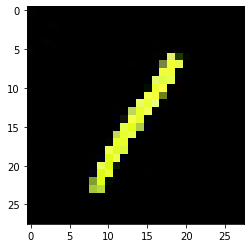

In [6]:
path = "MNIST/1/1.jpg"

# 1. 그림->숫자 함수 확인
arr = jpg_image_to_array(path, 28)
plt.imshow(arr, cmap=plt.get_cmap('gray'))

# 2. 1채널화 함수 확인

'''
[
[255,255,255,...255]
[255,255,255....255]
.
.
.
[255,255,255....255]
]
'''
arr_1c = image_array_to_1channel(arr) #원채널로
print(arr_1c.shape)


'''
[
[
[[255],[255],[255],...[255]]
[[255],[255],[255],...[255]]
.
.
.
[[255],[255],[255],...[255]]
]
]
'''
img_rows, img_cols = 28, 28
x_train = arr_1c.reshape(1, img_rows, img_cols, 1) #CNN모델에 적용할수 있게
print(x_train.shape)

y_pred = model.predict_classes(x_train)

In [7]:
import os
dir = "MNIST"

#폴더내의 모든 폴더or파일의 이름을 반환 os.listdir(), subdir_names=['1','2','5']
subdir_names = os.listdir(dir)


X_test = []
y_test = []
# (MNIST폴더)에서 (MNIST\\하위폴더)로 들어감
for subdir_name in subdir_names:
    subdir = dir+"\\"+subdir_name
    file_names = os.listdir(subdir) #해당폴더에 모든 파일을 입력
    for file_name in file_names:
        print("-------------  현재 파일이름 :",file_name,"---------------")
        path = subdir+"\\"+file_name
        arr = jpg_image_to_array(path, 28) #path는 상대경로로서 현재 디렉토리에서 하위로 들어감
        arr_1c = image_array_to_1channel(arr)  # convert to 1-channel
        print(arr_1c.shape)        
        if len(X_test)==0:
            X_test = [arr_1c]
            y_test = int(subdir_name)
            print("[ 현재 폴더 : ",subdir_name,"]")
        else:
            X_test = np.concatenate((X_test, [arr_1c]))
            y_test = np.append(y_test, int(subdir_name))
            print("[ 현재 폴더 : ",subdir_name,"]")

-------------  현재 파일이름 : 1.jpg ---------------
(2352,)
(28, 28, 3)
(28, 28)
[ 현재 폴더 :  1 ]
-------------  현재 파일이름 : 2.jpg ---------------
(2352,)
(28, 28, 3)
(28, 28)
[ 현재 폴더 :  2 ]
-------------  현재 파일이름 : 5.jpg ---------------
(2352,)
(28, 28, 3)
(28, 28)
[ 현재 폴더 :  5 ]
-------------  현재 파일이름 : 5_small.jpg ---------------
(2352,)
(28, 28, 3)
(28, 28)
[ 현재 폴더 :  5 ]


C:\anaconda\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


In [8]:
# CNN적용위해 끝차원 하나 늘림
print(X_test.shape)
X_test = np.expand_dims(X_test, axis=-1)
print(X_test.shape)

(4, 28, 28)
(4, 28, 28, 1)


In [9]:
# 모델을 통한 예측값
y_pred = model.predict_classes(X_test)
print(y_pred)

[1 2 5 5]


In [10]:
from tensorflow.keras import utils

# 결과값 원핫코딩
y_binary = utils.to_categorical(y_test, 10)
print(y_binary)

#평가
score = model.evaluate(X_test, y_binary)
print('test_loss: ', score[0])
print('test_acc: ', score[1])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
4/1 [========================================================================================================================] - 0s 40ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
test_loss:  0.0
test_acc:  1.0
